# Research Pathway 1 - Jitao Zhang

In [48]:
import oracledb
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import boxcox

## SQL queries to pull and organize required data from the database

In [49]:
# Connect
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user="ora_jitao888", password="a37274248", dsn=dsn)

# example
# dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
# connection = oracledb.connect(user="ora_wanqing1", password="a65768004", dsn=dsn)

# cur = connection.cursor()
# for row in cur.execute("select * from titles"):
#     print(row)
# cur.close()

In [50]:
cur = connection.cursor()

In [51]:
cur.execute("""
create or replace view hos_risk_count as 
select year, sum(Count_ICD10) as hospitalization_count, sum(Population_ICD10) as at_risk_count
from counties
group by year
""")

In [52]:
sql = """
select c.year, c.deaths, h.hospitalization_count, h.at_risk_count
from california c, hos_risk_count h
where c.year = h.year
"""

In [53]:
cur.execute(sql)
diabetes = cur.fetchall()
cur.close()

diabetes

[(2017, 9595, 223666, 242301560),
 (2019, 9854, 232276, 244452050),
 (2021, 11440, 227968, 243920984),
 (2016, 9124, 210524, 240485148),
 (2022, 11618, 241796, 244186520),
 (2018, 9506, 223582, 243703888),
 (2020, 11642, 213242, 245467320)]

In [54]:
diabetes_df = pd.DataFrame(diabetes, columns = ['year', 'death_count', 'hospitalization_count', 'risk_count'])
diabetes_df

,year,death_count,hospitalization_count,risk_count
0,2017,9595,223666,242301560
1,2019,9854,232276,244452050
2,2021,11440,227968,243920984
3,2016,9124,210524,240485148
4,2022,11618,241796,244186520
5,2018,9506,223582,243703888
6,2020,11642,213242,245467320


## Further data analysis through python

### First attempt of fitting a linear regression model:

In [55]:
X = diabetes_df[['hospitalization_count', 'risk_count']]
y = diabetes_df['death_count']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            death_count   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     2.156
Date:                Tue, 01 Apr 2025   Prob (F-statistic):              0.232
Time:                        04:23:56   Log-Likelihood:                -55.959
No. Observations:                   7   AIC:                             117.9
Df Residuals:                       4   BIC:                             117.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -1.05e+

/opt/conda/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


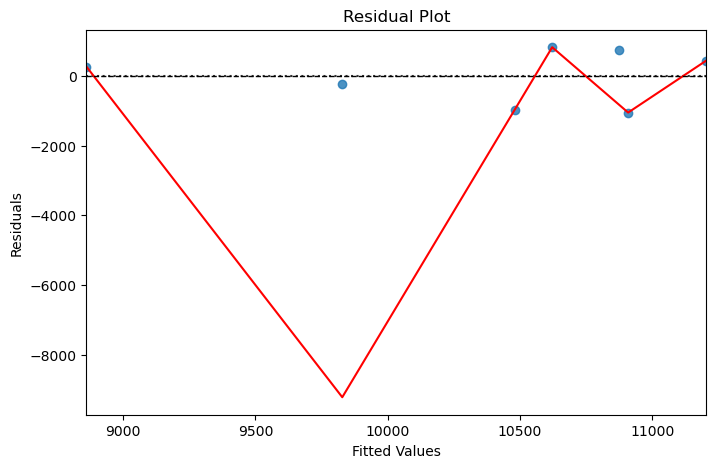

In [56]:
fitted_values = model.fittedvalues
residuals = model.resid

# Plot the residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1.5})
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

### Second attempt of adding an interaction term:

In [57]:
diabetes_df['hospitalization_risk_interaction'] = diabetes_df['hospitalization_count'] * diabetes_df['risk_count']

X_2 = diabetes_df[['hospitalization_count', 'risk_count', 'hospitalization_risk_interaction']]
X_2 = sm.add_constant(X_2)

# Fit the linear regression model with interaction
model_interaction = sm.OLS(y, X_2).fit()

print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:            death_count   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     2.171
Date:                Tue, 01 Apr 2025   Prob (F-statistic):              0.230
Time:                        04:23:57   Log-Likelihood:                -55.947
No. Observations:                   7   AIC:                             117.9
Df Residuals:                       4   BIC:                             117.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

/opt/conda/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


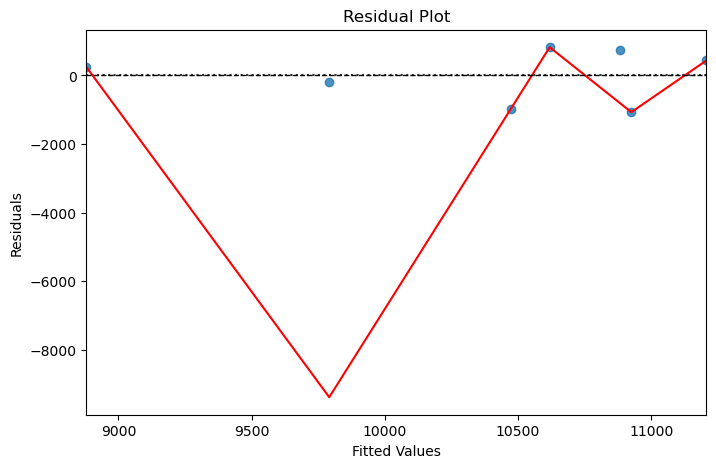

In [58]:
fitted_values = model_interaction.fittedvalues
residuals = model_interaction.resid

# Plot the residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1.5})
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()